In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm
from matplotlib.legend import Legend
%matplotlib inline

import sys, os
from joblib import Parallel, delayed

sys.path.append(os.path.realpath('..'))
from benchmarks import power_4samp_2way_epsweight
from hyppo.sims import gaussian_4samp_2way
from hyppo.independence import MGC, Dcorr

import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])
np.set_printoptions(precision=3)

In [2]:
MAX_EPSILON1 = 1
MAX_EPSILON2 = 1
STEP_SIZE = 0.1#0.05
EPSILONS1 = np.arange(0, MAX_EPSILON1 + STEP_SIZE, STEP_SIZE)
EPSILONS2 = [None]#np.arange(0, MAX_EPSILON2 + STEP_SIZE, STEP_SIZE)
WEIGHTS = EPSILONS1
POWER_REPS = 2#5
REPS = 100

tests = [
    Dcorr,
]

multiways = [
    True,
    False,
]

effect_masks = [
    [0,1,0,0],
    [0,0,1,0],
    [0,1,0,1],
    [0,1,1,0],
    [0,1,1,1]
]

FONTSIZE = 12

In [19]:
def estimate_power(test, multiway, effect_mask):
    est_power = np.array([
        [
            np.mean([power_4samp_2way_epsweight(test, workers=-1, epsilon1=i, effect_mask=effect_mask, epsilon2=j, reps=REPS, multiway=multiway, compute_distance=None)
                for _ in range(POWER_REPS)
            ]) 
            for i in EPSILONS1
        ]
        for j in EPSILONS2
    ])
    np.savetxt('../benchmarks/4samp_2way_vs_epsilon/{}_{}_{}.csv'.format(multiway, test.__name__, "".join([str(em) for em in effect_mask])),
               est_power, delimiter=',')
    
    return est_power

In [20]:
outputs = []
for effect_mask in effect_masks:
    output = Parallel(n_jobs=-1, verbose=100)(
        [delayed(estimate_power)(test, multiway, effect_mask) for test in tests for multiway in multiways]
    )
    outputs.append(output)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  9.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  9.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  9.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elaps

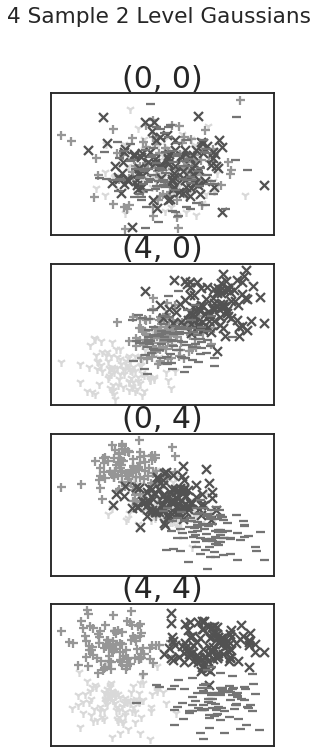

In [22]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(4,12))
    
sim_title = [
    "4 Sample 2 Level Gaussians",
]

epsilons = [
    (0,0),
    (4,0), # 1st level separate
    (0,4), # 2nd level separate
    (4,4), # Both separate
]

ax = np.array([ax]).reshape((4,-1))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        ep1, ep2 = epsilons[i]
        sims = gaussian_4samp_2way(100, epsilon1=ep1, epsilon2=ep2)

        sim_markers = [
            "1",
            "+",
            "x",
            '_',
        ]
        custom_color = [
            "#d9d9d9",
            "#969696",
            "#525252",
            "#747474",
        ]

        count = 0
        scatters = []
        for sim in sims:
            x, y = np.hsplit(sim, 2)
            scatters.append(col.scatter(x, y, marker=sim_markers[count], color=custom_color[count]))

            #col.set_xlim(-5, 5)
            #if case not in [2, 4]:
            #    col.set_ylim(-5, 5)
            col.set_xticks([])
            col.set_yticks([])
            col.set_title(epsilons[i], fontsize=FONTSIZE)
            count += 1
            
plt.suptitle(sim_title[0])
plt.show()

<IPython.core.display.Javascript object>


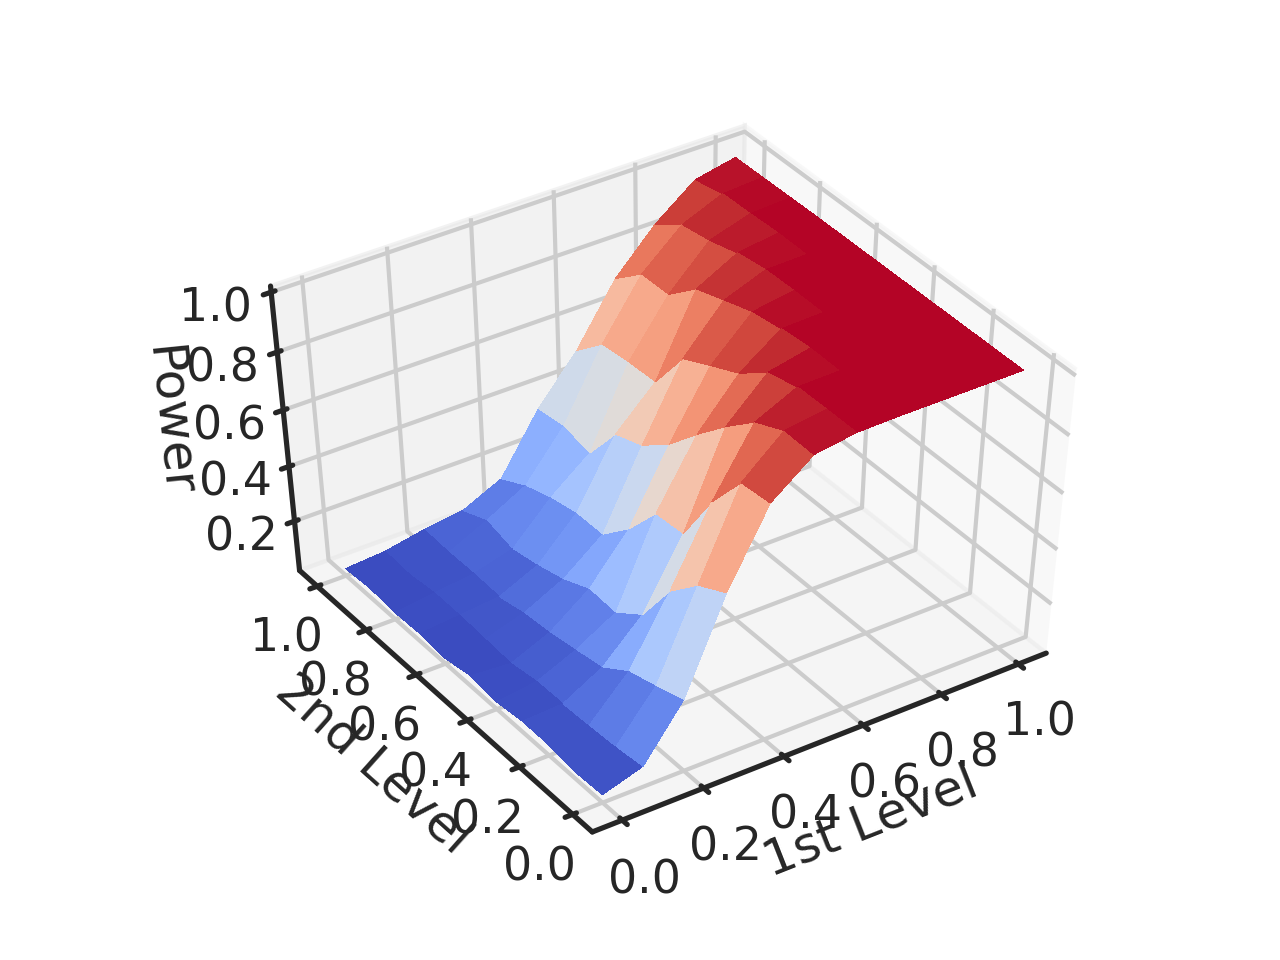

In [39]:
fig = plt.figure()
ax = fig.gca(projection='3d')

for test in tests:
    for multiway in multiways:
        power = np.genfromtxt(
            '../benchmarks/4samp_2way_vs_epsilon/{}_{}.csv'.format(multiway, test.__name__),
            delimiter=','
        )

        custom_color = {
            "Dcorr" : "#377eb8",
            "Hsic" : "#4daf4a",
            "MGC" : "#e41a1c",
        }
        if multiway:
                label = f'Multiway {test.__name__}'
        else:
            label = f'{test.__name__}'
            
        X, Y = np.meshgrid(EPSILONS1, EPSILONS2)
        
        surf = ax.plot_surface(X, Y, power, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
        
        ax.set_xlabel('1st Level') # Epsilon 1 / Highest level / 
        ax.set_ylabel('2nd Level') # Epsilon 2
        ax.set_zlabel('Power')

plt.show()

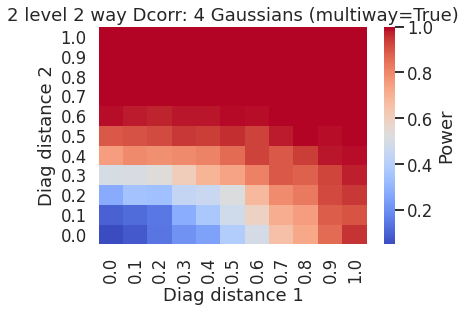

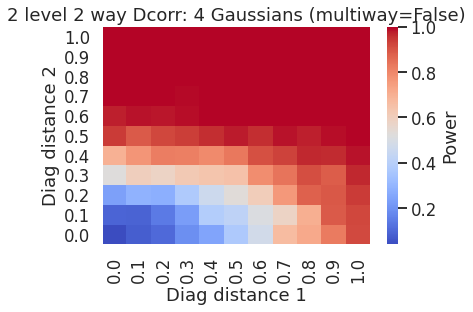

In [12]:
for test in tests:
    for multiway in multiways:
        power = np.genfromtxt(
            '../benchmarks/4samp_2way_vs_epsilon/{}_{}.csv'.format(multiway, test.__name__),
            delimiter=','
        )
        ax = sns.heatmap(
            power,
            cmap=cm.coolwarm,
            xticklabels=np.round(EPSILONS1 ,2),
            yticklabels=np.round(EPSILONS2 ,2),
            cbar_kws={'label': 'Power'}
        )
        ax.invert_yaxis()
        plt.xlabel('Diag distance 1') # Epsilon 1
        plt.ylabel('Diag distance 2') # Epsilon 2
        
        plt.title(f'2 level 2 way {test.__name__}: 4 Gaussians (multiway={multiway})')
        plt.show()

In [51]:
FONTSIZE = 12

def plot_power():
    fig, ax = plt.subplots(nrows=2, ncols=len(effect_masks), figsize=(16,10))
    
    sim_title = [
        f"Four Gaussians {''.join([str(em) for em in effect_mask])}" for effect_mask in effect_masks
    ]
    
    ax = np.array([ax]).reshape((2,-1))
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            if i == 0:
                sims = gaussian_4samp_2way(100, epsilon1=4, epsilon2=None, effect_mask=effect_masks[j])
                
                sim_markers = [
                    "1",
                    "+",
                    "x",
                    '_',
                ]
                custom_color = [
                    "#d9d9d9",
                    "#969696",
                    "#525252",
                    "#747474",
                ]
                
                count = 0
                scatters = []
                for sim in sims:
                    x, y = np.hsplit(sim, 2)
                    scatters.append(col.scatter(x, y, marker=sim_markers[count], color=custom_color[count]))

                    #col.set_xlim(-5, 5)
                    #if case not in [2, 4]:
                    #    col.set_ylim(-5, 5)
                    col.set_xticks([])
                    col.set_yticks([])
                    col.set_title(sim_title[j], fontsize=FONTSIZE)
                    count += 1
            else:
                for test in tests:
                    for multiway in multiways:
                        power = np.genfromtxt(
                            '../benchmarks/4samp_2way_vs_epsilon/{}_{}_{}.csv'.format(
                                multiway, 
                                test.__name__,
                                "".join([str(em) for em in effect_masks[j]])
                                ),
                            delimiter=','
                            )

                        custom_color = {
                            "Dcorr" : "#377eb8",
                            "Hsic" : "#4daf4a",
                            "MGC" : "#e41a1c",
                        }
                        if multiway:
                                label = f'Multiway {test.__name__}'
                        else:
                            label = f'{test.__name__}'
                        if test.__name__ in custom_color.keys():
                            if multiway:#test.__name__ == "MGC":
                                col.plot(EPSILONS1, power, "#e41a1c", label=label, lw=3)
                            else:
                                col.plot(EPSILONS1, power, custom_color[test.__name__], label=label, ls='-', lw=3)
                        else:
                            col.plot(EPSILONS1, power, label=label, lw=2)
                        col.tick_params(labelsize=FONTSIZE)
                        col.set_xticks([EPSILONS1[0], EPSILONS1[-1]])
                        col.set_ylim(0, 1.05)
                        col.set_yticks([])
                        if j == 0:
                            col.set_yticks([0, 1])
    
    fig.text(0.5, 0.05, 'Cluster Separation', ha='center', fontsize=FONTSIZE)
#     fig.text(0.75, 0, 'Increasing Weight', ha='center')
    fig.text(0.1, 0.3, 'Power', va='center', rotation='vertical', fontsize=FONTSIZE)
    fig.text(0.1, 0.7, 'Scatter Plots', va='center', rotation='vertical', fontsize=FONTSIZE)
    
    leg = plt.legend(bbox_to_anchor=(0.97, 0.45), bbox_transform=plt.gcf().transFigure,
                     ncol=1, loc='upper center', fontsize=FONTSIZE)
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.20)
    leg = Legend(fig, scatters, ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], loc='upper left', frameon=False, ncol=1,
                bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(0.9, 0.9), fontsize=FONTSIZE)
    fig.add_artist(leg);
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3)
    #plt.savefig('../benchmarks/figs/4samp_power_epsilon.pdf', transparent=True, bbox_inches='tight')

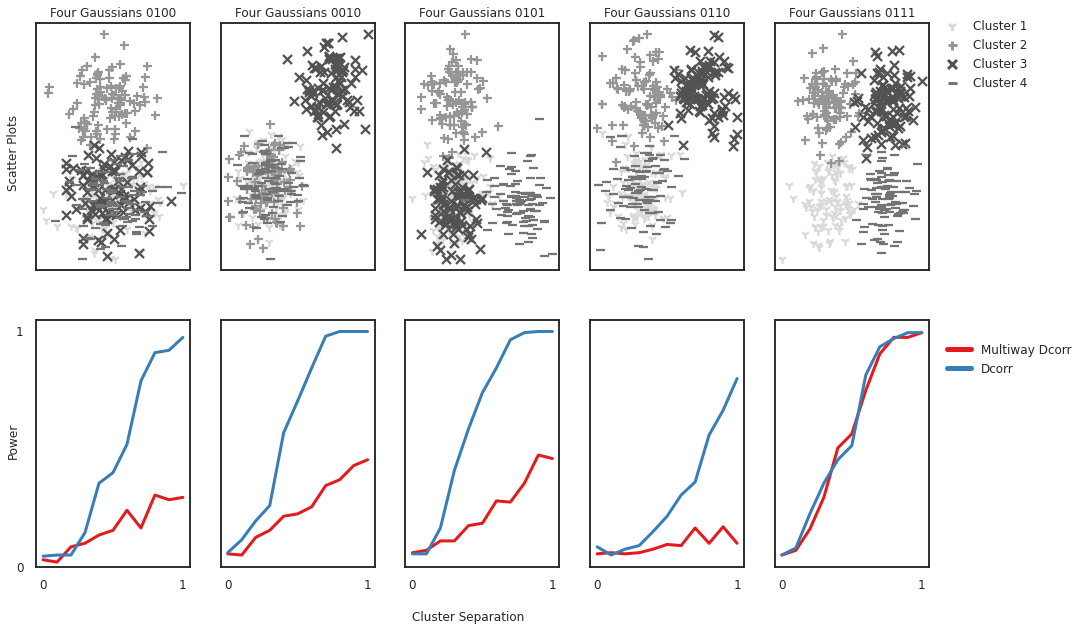

In [52]:
plot_power()

In [36]:
(np.asarray(effect_masks[0]) != 0) * np.asarray([2,2,2,2])

array([0, 2, 0, 0])

In [54]:
import pickle

In [55]:
with open('/home/rflperry/meditation/data/ksample_tests/DCORR_6-sample_results_dict_10000_min_rank-ZG3.pkl', 'rb') as handle:
    d = pickle.load(handle)

In [56]:
d

{'6-sample ([[0], [1], [2], [3], [4], [5]])': {0: {'pvalue': 0.1042,
   'test_stat': -0.00891862748831176},
  1: {'pvalue': 0.0396, 'test_stat': -0.006631728946249153},
  2: {'pvalue': 0.0003, 'test_stat': 0.009470594868090758},
  (0, 1): {'pvalue': 0.0309, 'test_stat': -0.008527222670002579},
  (1, 2): {'pvalue': 0.0003, 'test_stat': 0.0029978206860200324},
  (2, 0): {'pvalue': 0.0007, 'test_stat': 0.002568163049061012},
  (0, 1, 2): {'pvalue': 0.0016, 'test_stat': -0.0007846015504349085}}}